In [1]:
#Info about the variables

In [2]:
# Initial imports
import pandas as pd
from pathlib import Path

from sklearn import tree
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

import tensorflow as tf

2023-08-17 15:49:31.932215: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# Loading data
file_path = Path("Resources/retail_price_cleaned.csv")
df_sales = pd.read_csv(file_path)
df_sales.head()

,product_id,product_category_name,month_year,qty_sold,total_price,freight_price,unit_price,product_rating,no_customers,month,...,comp1_price,comp1_prod_rating,comp1_freight_price,comp2_price,comp2_prod_rating,comp2_freight_price,comp3_price,comp3_prod_rating,comp3_freight_price,lag_price
0,bed1,bed_bath_table,01-05-2017,1,45.95,15.100000,45.95,4.0,57,5,...,89.9,3.9,15.011897,215.000000,4.4,8.760000,45.95,4.0,15.100000,45.90
1,bed1,bed_bath_table,01-06-2017,3,137.85,12.933333,45.95,4.0,61,6,...,89.9,3.9,14.769216,209.000000,4.4,21.322000,45.95,4.0,12.933333,45.95
2,bed1,bed_bath_table,01-07-2017,6,275.70,14.840000,45.95,4.0,123,7,...,89.9,3.9,13.993833,205.000000,4.4,22.195932,45.95,4.0,14.840000,45.95
3,bed1,bed_bath_table,01-08-2017,4,183.80,14.287500,45.95,4.0,90,8,...,89.9,3.9,14.656757,199.509804,4.4,19.412885,45.95,4.0,14.287500,45.95
4,bed1,bed_bath_table,01-09-2017,2,91.90,15.100000,45.95,4.0,54,9,...,89.9,3.9,18.776522,163.398710,4.4,24.324687,45.95,4.0,15.100000,45.95


In [4]:
df_sales.nunique()

product_id                52
product_category_name      9
month_year                20
qty_sold                  66
total_price              573
freight_price            653
unit_price               280
product_rating            11
no_customers              94
month                     12
year                       2
seasonality              450
volume                    40
comp1_price               88
comp1_prod_rating          9
comp1_freight_price      179
comp2_price              123
comp2_prod_rating         10
comp2_freight_price      242
comp3_price              105
comp3_prod_rating          9
comp3_freight_price      229
lag_price                307
dtype: int64

## EDA

In [5]:
# Turn dates into datetime for "year","month","month_year"
df_sales['year'] = pd.to_datetime(df_sales['month_year'], format='%d-%m-%Y').dt.year 
df_sales['month'] = pd.to_datetime(df_sales['month_year'], format='%d-%m-%Y').dt.month
df_sales['month_year'] = pd.to_datetime(df_sales['month_year'], format='%d-%m-%Y').dt.strftime('%Y-%m') #.d

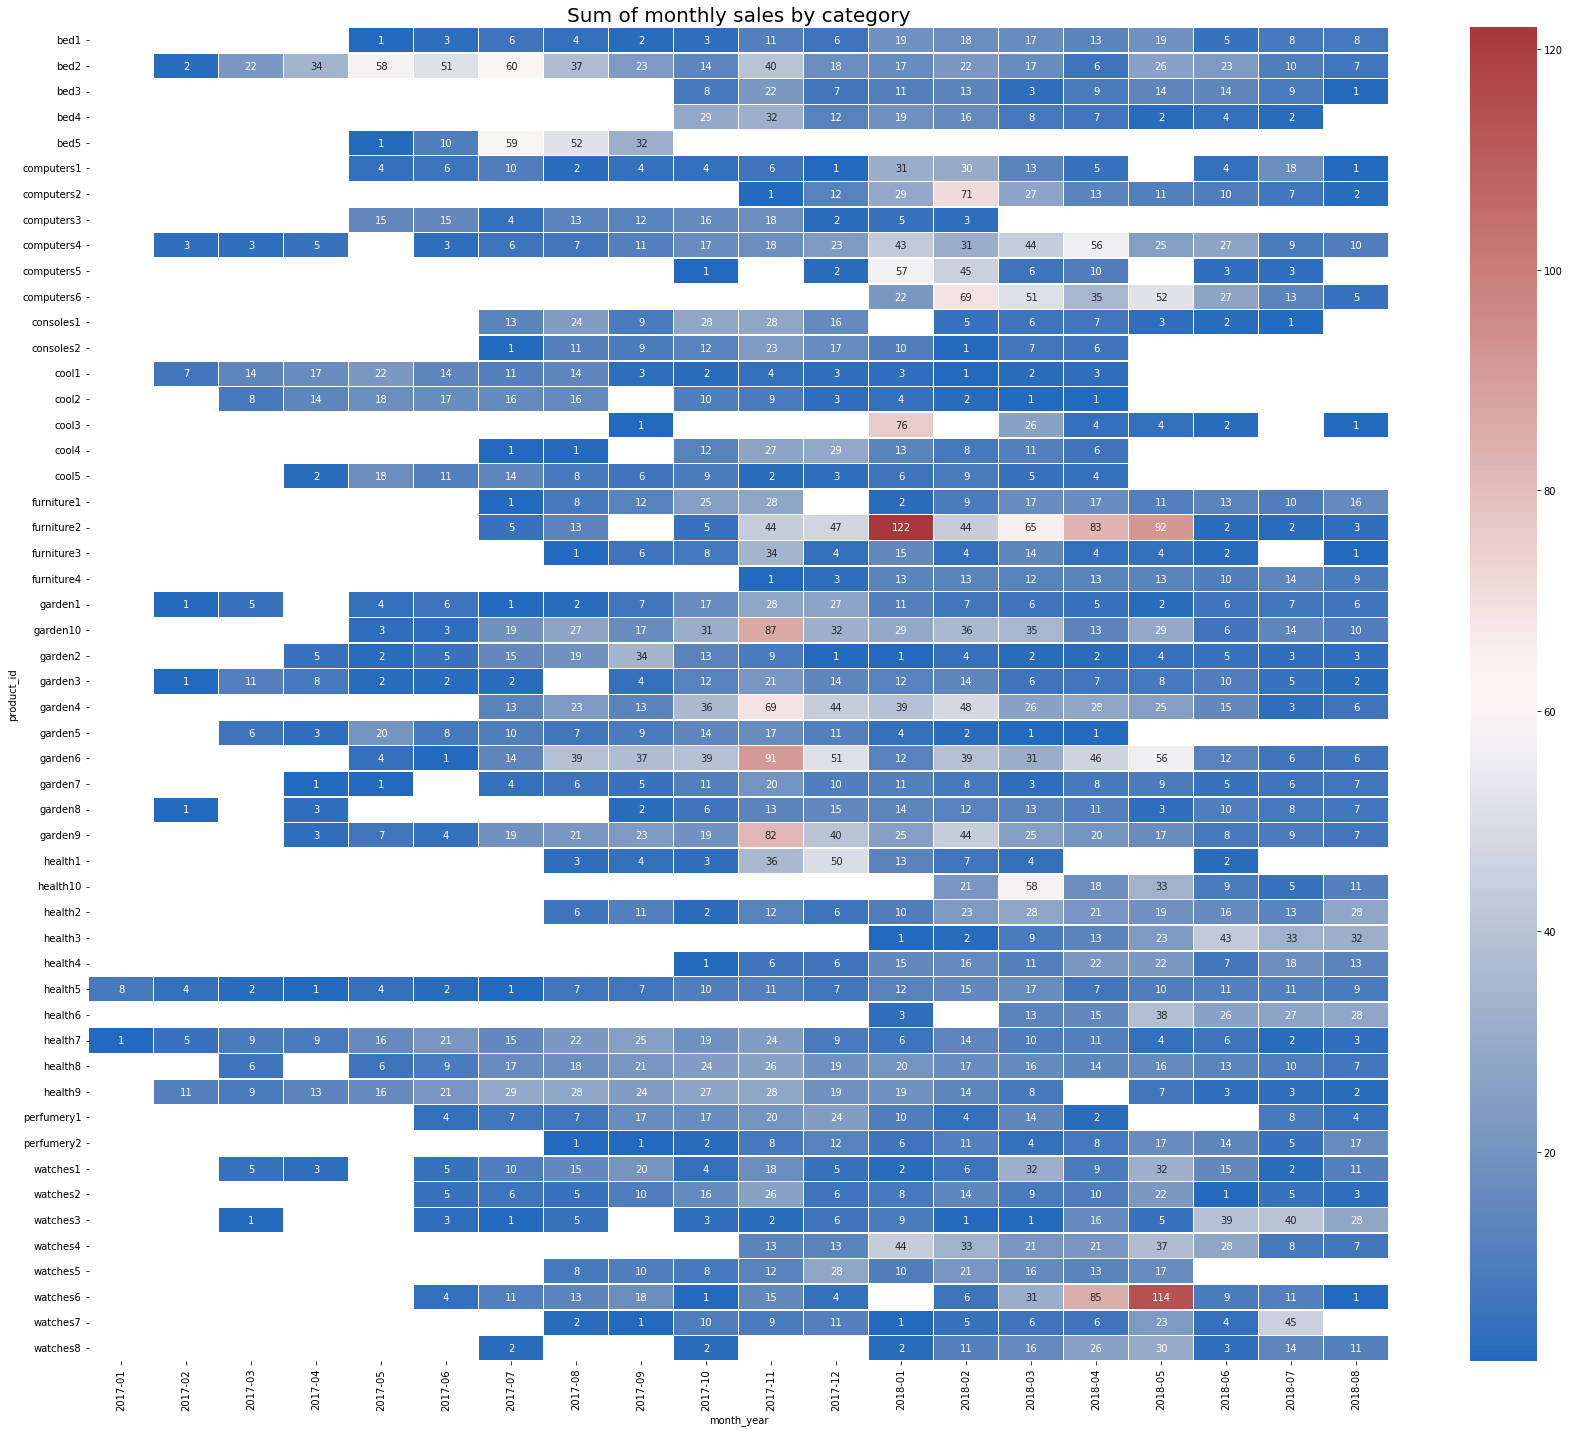

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create pivot table Quantity sold per Date Vs. product_category_name by month
temp = df_sales.pivot_table(
    values='qty_sold',
    index='product_id',
    columns='month_year',
    aggfunc='sum',
    ) 
    
# adjust size
fig,ax = plt.subplots(figsize=(24, 20))

# Create heatmap of the above pivot_table.
fig = sns.heatmap(temp, annot=True, fmt='.0f',  linewidths=.5, cmap= 'vlag')

#Set title
ax.set_title('Sum of monthly sales by category', y=-0.5, fontsize=20);

#Rotate x axis
ax.tick_params(axis='x', rotation=90)

#Plot
plt.tight_layout()

In [7]:
df_sales_copy = df_sales.copy()

## Prep

In [8]:
df_sales_copy = df_sales.copy()

In [9]:
df_sales_copy['qty_sold'].value_counts()

1      48
2      46
6      42
3      39
4      37
       ..
48      1
47      1
46      1
38      1
122     1
Name: qty_sold, Length: 66, dtype: int64

In [10]:
quantity  = []

for x in df_sales_copy['qty_sold']:
    if x >= 10:
        new_rating = 1
    else: new_rating = 0
    quantity.append(new_rating)

print(quantity)

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 

In [11]:
df_sales_copy["quantity"] = quantity

In [12]:
# Drop uneeded columns
df_sales_copy.drop(['product_id','month_year', 'year', 'qty_sold', 'lag_price', 'product_category_name','qty_sold'], axis=1, inplace=True)


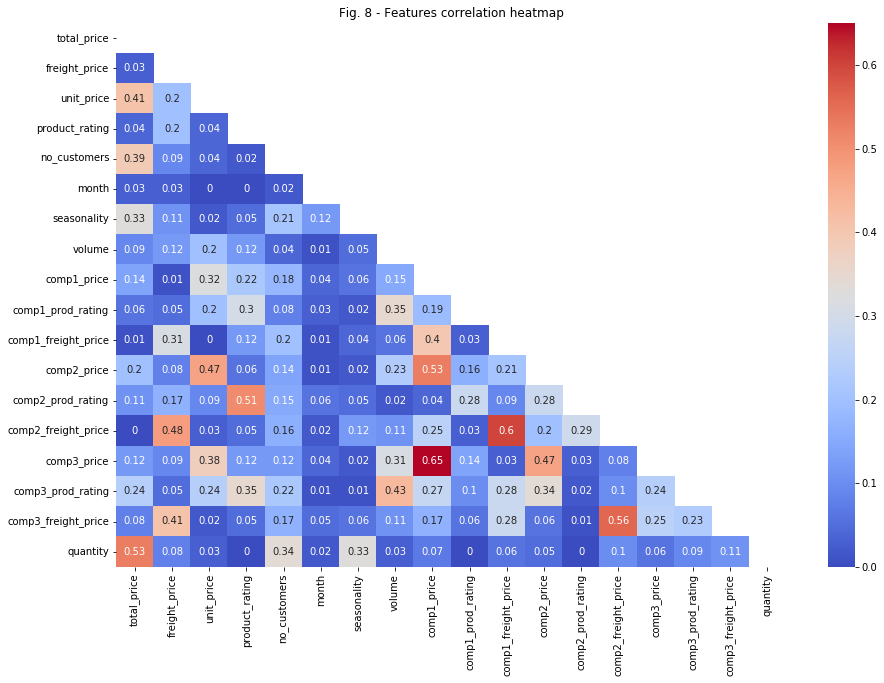

In [13]:
#Correlation heatmap
import numpy as np
fig, ax = plt.subplots(figsize=(15, 10))

matrix = np.triu(df_sales_copy.corr())  
fig = sns.heatmap(round(abs(df_sales_copy.corr()),2), annot=True,  cmap= 'coolwarm', mask=matrix) #, vmin=-1, vmax=1, center= 0, fmt='.02g',
ax.set_title('Fig. 8 - Features correlation heatmap', y=-0.15, fontsize=12);

## ML modeling

In [14]:
# Seperate the features, X,  from the target variable, y
y = df_sales_copy['quantity']
X = df_sales_copy.drop(columns='quantity').values

In [15]:
# Splitting into Train and Test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

In [16]:
#Scale

# Instantiate a StandardScaler instance
scaler = StandardScaler()

# Fit the training data to the standard scaler
X_scaler = scaler.fit(X_train)

# Transform the training data using the scaler
X_train_scaled = X_scaler.transform(X_train)

# Transform the testing data using the scaler
X_test_scaled = X_scaler.transform(X_test)

In [21]:
# Define the model - deep neural net
number_input_features = len(X_train[0])
hidden_nodes_layer1 =  50
hidden_nodes_layer2 = 25

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(
    tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu")
)

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="relu"))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="relu"))

# Check the structure of the model
nn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 50)                900       
                                                                 
 dense_4 (Dense)             (None, 25)                1275      
                                                                 
 dense_5 (Dense)             (None, 1)                 26        
                                                                 
Total params: 2,201
Trainable params: 2,201
Non-trainable params: 0
_________________________________________________________________


In [22]:
# Compile the model
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [23]:
# Train the model
fit_model = nn.fit(X_train_scaled,y_train,epochs=100)

Epoch 1/100
16/16 [==============================] - 1s 2ms/step - loss: 5.7675 - accuracy: 0.4517
Epoch 2/100
16/16 [==============================] - 0s 3ms/step - loss: 3.2215 - accuracy: 0.4911
Epoch 3/100
16/16 [==============================] - 0s 3ms/step - loss: 2.4176 - accuracy: 0.5365
Epoch 4/100
16/16 [==============================] - 0s 2ms/step - loss: 2.0334 - accuracy: 0.5562
Epoch 5/100
16/16 [==============================] - 0s 3ms/step - loss: 1.7124 - accuracy: 0.5937
Epoch 6/100
16/16 [==============================] - 0s 4ms/step - loss: 1.3615 - accuracy: 0.6272
Epoch 7/100
16/16 [==============================] - 0s 4ms/step - loss: 1.2054 - accuracy: 0.6548
Epoch 8/100
16/16 [==============================] - 0s 4ms/step - loss: 1.0320 - accuracy: 0.6884
Epoch 9/100
16/16 [==============================] - 0s 6ms/step - loss: 0.9833 - accuracy: 0.6785
Epoch 10/100
16/16 [==============================] - 0s 3ms/step - loss: 0.9050 - accuracy: 0.6864
Epoch 11/

16/16 [==============================] - 0s 3ms/step - loss: 0.1354 - accuracy: 0.9606
Epoch 84/100
16/16 [==============================] - 0s 3ms/step - loss: 0.1333 - accuracy: 0.9645
Epoch 85/100
16/16 [==============================] - 0s 3ms/step - loss: 0.1300 - accuracy: 0.9645
Epoch 86/100
16/16 [==============================] - 0s 3ms/step - loss: 0.1284 - accuracy: 0.9665
Epoch 87/100
16/16 [==============================] - 0s 2ms/step - loss: 0.1261 - accuracy: 0.9704
Epoch 88/100
16/16 [==============================] - 0s 2ms/step - loss: 0.1228 - accuracy: 0.9704
Epoch 89/100
16/16 [==============================] - 0s 2ms/step - loss: 0.1208 - accuracy: 0.9724
Epoch 90/100
16/16 [==============================] - 0s 2ms/step - loss: 0.1189 - accuracy: 0.9704
Epoch 91/100
16/16 [==============================] - 0s 3ms/step - loss: 0.1171 - accuracy: 0.9744
Epoch 92/100
16/16 [==============================] - 0s 2ms/step - loss: 0.1158 - accuracy: 0.9783
Epoch 93/100


In [24]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")


6/6 - 0s - loss: 0.6539 - accuracy: 0.8817 - 233ms/epoch - 39ms/step
Loss: 0.653892993927002, Accuracy: 0.88165682554245
